In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import mlflow
from mlflow.models import infer_signature

In [3]:
def preprocessing_data_frame(frame):
    df = frame.copy()
    cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
    num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']
    
    question_dist = df[(df.Year <2021) & (df.Distance < 1100)]
    df = df.drop(question_dist.index)
    # Анализ и очистка данных
    # анализ гистограмм
    question_dist = df[(df.Distance > 1e6)]
    df = df.drop(question_dist.index)
    
    # здравый смысл
    question_engine = df[df["Engine_capacity(cm3)"] < 200]
    df = df.drop(question_engine.index)
    
    # здравый смысл
    question_engine = df[df["Engine_capacity(cm3)"] > 5000]
    df = df.drop(question_engine.index)
    
    # здравый смысл
    question_price = df[(df["Price(euro)"] < 101)]
    df = df.drop(question_price.index)
    
    # анализ гистограмм
    question_price = df[df["Price(euro)"] > 1e5]
    df = df.drop(question_price.index)
    
    #анализ гистограмм
    question_year = df[df.Year < 1971]
    df = df.drop(question_year.index)
    
    df = df.reset_index(drop=True)  # обновим индексы в датафрейме DF. если бы мы прописали drop = False, то была бы еще одна колонка - старые индексы
    # Разделение данных на признаки и целевую переменную
    
    
    # Предварительная обработка категориальных данных
    # Порядковое кодирование. Обучение, трансформация и упаковка в df
    
    ordinal = OrdinalEncoder()
    ordinal.fit(df[cat_columns]);
    Ordinal_encoded = ordinal.transform(df[cat_columns])
    df_ordinal = pd.DataFrame(Ordinal_encoded, columns=cat_columns)
    df[cat_columns] = df_ordinal[cat_columns]
    return df

def scale_frame(frame):
    df = frame.copy()
    X,y = df.drop(columns = ['Price(euro)']), df['Price(euro)']
    scaler = StandardScaler()
    power_trans = PowerTransformer()
    X_scale = scaler.fit_transform(X.values)
    Y_scale = power_trans.fit_transform(y.values.reshape(-1,1))
    return X_scale, Y_scale, power_trans

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_no_dup.csv', delimiter = ',')
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0


In [5]:
df_proc = preprocessing_data_frame(df)
X,Y, power_trans = scale_frame(df_proc)
# разбиваем на тестовую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=0.3,
                                                  random_state=42)

In [6]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [13]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [34]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1 ],
      'l1_ratio': [0.001, 0.05, 0.01, 0.2]
 }
with mlflow.start_run():
    lr = SGDRegressor(random_state=42)
    clf = GridSearchCV(lr, params, cv = 5)
    clf.fit(X_train, y_train.reshape(-1))
    best = clf.best_estimator_
    y_pred = best.predict(X_val)
    y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1,1))
    (rmse, mae, r2)  = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)
    alpha = best.alpha
    l1_ratio = best.l1_ratio
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    predictions = best.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(lr, "model", signature=signature)
   

2025/04/07 02:41:55 INFO mlflow.sklearn.utils: Logging the 5 best runs, 15 runs will be omitted.


🏃 View run capricious-pig-762 at: http://127.0.0.1:5000/#/experiments/0/runs/5f9a7d2eaca241d98255b6b2b68378ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run righteous-sponge-153 at: http://127.0.0.1:5000/#/experiments/0/runs/fb9b0293f5d5440fbab9d2a603bae778
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run magnificent-calf-25 at: http://127.0.0.1:5000/#/experiments/0/runs/bbede8a13ac94773a4c8b537ad5303ad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run amusing-dove-830 at: http://127.0.0.1:5000/#/experiments/0/runs/670beee2f50549919faa827148402e0a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run masked-yak-39 at: http://127.0.0.1:5000/#/experiments/0/runs/78f455967d994d6999e57d4ccf996003
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run beautiful-gull-412 at: http://127.0.0.1:5000/#/experiments/0/runs/14ff3ac7997f4b15bffcc5b41a4ee76e
🧪 View experiment at: http://127.0.0.1:5000/

## Cвои данные

In [16]:
def preprocessing_data_frame(frame):
    df = frame.copy()
    cat_columns = ['Gender', 'Education Level', 'Job Title']
    num_columns = ['Age', 'Years of Experience', 'Salary']
    
    question_age = df[(df['Age'] < 0)]
    df = df.drop(question_age.index)
    
    question_age = df[(df['Age'] > 100)]
    df = df.drop(question_age.index)
    
    question_years_of_experience = df[(df['Years of Experience'] > 80)]
    df = df.drop(question_years_of_experience.index)
    
    question_years_of_experience = df[(df['Years of Experience'] < 0)]
    df = df.drop(question_years_of_experience.index)
    
    question_salary = df[(df['Salary'] > 250000)]
    df = df.drop(question_salary.index)
    
    question_salary = df[(df['Salary'] < 0)]
    df = df.drop(question_salary.index)
    
    df = df.dropna(subset=['Age', 'Years of Experience', 'Salary', 'Gender', 'Education Level', 'Job Title'])
    df = df.reset_index(drop=True)
    
    ordinal = OrdinalEncoder()
    ordinal.fit(df[cat_columns]);
    Ordinal_encoded = ordinal.transform(df[cat_columns])
    df_ordinal = pd.DataFrame(Ordinal_encoded, columns=cat_columns)
    df[cat_columns] = df_ordinal[cat_columns]
    return df

def scale_frame(frame):
    df = frame.copy()
    X,y = df.drop(columns = ['Salary']), df['Salary']
    scaler = StandardScaler()
    power_trans = PowerTransformer()
    X_scale = scaler.fit_transform(X.values)
    Y_scale = power_trans.fit_transform(y.values.reshape(-1,1))
    return X_scale, Y_scale, power_trans

In [17]:
df = pd.read_csv('Salary_DB.csv', delimiter = ',')
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [18]:
df_proc = preprocessing_data_frame(df)
X,Y, power_trans = scale_frame(df_proc)
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=0.3,
                                                  random_state=42)

In [19]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [43]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5 ],
      'l1_ratio': [0.0001, 0.001, 0.05, 0.01, 0.1, 0.5]
 }
with mlflow.start_run():

    lr = SGDRegressor(random_state=100)
    clf = GridSearchCV(lr, params, cv = 15)
    clf.fit(X_train, y_train.reshape(-1))
    best = clf.best_estimator_
    y_pred = best.predict(X_val)
    y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1,1))
    (rmse, mae, r2)  = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)
    alpha = best.alpha
    l1_ratio = best.l1_ratio
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    predictions = best.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(lr, "model", signature=signature)

2025/04/07 02:49:33 INFO mlflow.sklearn.utils: Logging the 5 best runs, 31 runs will be omitted.


🏃 View run awesome-trout-701 at: http://127.0.0.1:5000/#/experiments/0/runs/3c861793c25044a5b51dbd1e489118f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bright-doe-261 at: http://127.0.0.1:5000/#/experiments/0/runs/7bf0227be1ff4610ab3270655f8ff690
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run shivering-skunk-770 at: http://127.0.0.1:5000/#/experiments/0/runs/17edfcb61c6c4aed8ca3191136fb9399
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run incongruous-frog-480 at: http://127.0.0.1:5000/#/experiments/0/runs/4c7612273fd4448f89a10a630bd16f90
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run bedecked-fox-44 at: http://127.0.0.1:5000/#/experiments/0/runs/97f5ad54a320452f86fc7c25cfe48409
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
🏃 View run angry-goose-422 at: http://127.0.0.1:5000/#/experiments/0/runs/867e99166a3e413b8fdd097a7f3e1678
🧪 View experiment at: http://127.0.0.1:5000/#/ex

In [46]:
from mlflow.tracking import MlflowClient
import pandas as pd


client = MlflowClient()
experiments = client.search_experiments()

data = []
for exp in experiments:
    runs = client.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="attributes.status = 'FINISHED'"  
    )
    for run in runs:
        data.append({
            "experiment_id": exp.experiment_id,
            "run_id": run.info.run_id,
            "status": run.info.status,  
            **run.data.metrics,                
        })

df_metrics = pd.DataFrame(data)
df_metrics.head(10)

,experiment_id,run_id,status,training_mean_absolute_error,training_mean_squared_error,training_r2_score,training_root_mean_squared_error,training_score,mean_fit_time,mean_score_time,mean_test_score,rank_test_score,std_fit_time,std_score_time,std_test_score,best_cv_score,mae,r2,rmse
0,0,7bf40320630945a7b723085343befad3,FINISHED,0.472512,0.355334,0.651714,0.596099,0.651714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,17edfcb61c6c4aed8ca3191136fb9399,FINISHED,NaN,NaN,NaN,NaN,NaN,0.003022,0.000469,0.659458,1.0,0.000226,0.000501,0.029555,NaN,NaN,NaN,NaN
2,0,3c861793c25044a5b51dbd1e489118f4,FINISHED,NaN,NaN,NaN,NaN,NaN,0.003024,0.000668,0.659458,1.0,0.000402,0.000473,0.029555,NaN,NaN,NaN,NaN
3,0,4c7612273fd4448f89a10a630bd16f90,FINISHED,NaN,NaN,NaN,NaN,NaN,0.003239,0.000626,0.659458,1.0,0.000650,0.000518,0.029555,NaN,NaN,NaN,NaN
4,0,7bf0227be1ff4610ab3270655f8ff690,FINISHED,NaN,NaN,NaN,NaN,NaN,0.003128,0.000602,0.659458,1.0,0.000452,0.000491,0.029555,NaN,NaN,NaN,NaN
5,0,867e99166a3e413b8fdd097a7f3e1678,FINISHED,0.466725,0.337353,0.659690,0.580821,0.659690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.659458,25487.652273,0.623688,32684.694612
6,0,97f5ad54a320452f86fc7c25cfe48409,FINISHED,NaN,NaN,NaN,NaN,NaN,0.003092,0.000601,0.659458,1.0,0.000401,0.000491,0.029555,NaN,NaN,NaN,NaN
7,0,7827824e503b490f8020a91ff8c19936,FINISHED,0.472512,0.355334,0.651714,0.596099,0.651714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,16be87a8e63f4119aeae0f5a540998c0,FINISHED,0.461606,0.336573,0.660476,0.580149,0.660476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.658880,25280.030586,0.621044,32799.340085
9,0,23eb1befd3404a02b9720749c57692a6,FINISHED,NaN,NaN,NaN,NaN,NaN,0.003070,0.001052,0.658880,1.0,0.000359,0.000140,0.018628,NaN,NaN,NaN,NaN


2025/04/07 02:50:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2b8878189663408d80e0beab8b786361', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
C:\Users\Artem Markov\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


🏃 View run luxuriant-finch-330 at: http://127.0.0.1:5000/#/experiments/0/runs/2b8878189663408d80e0beab8b786361
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


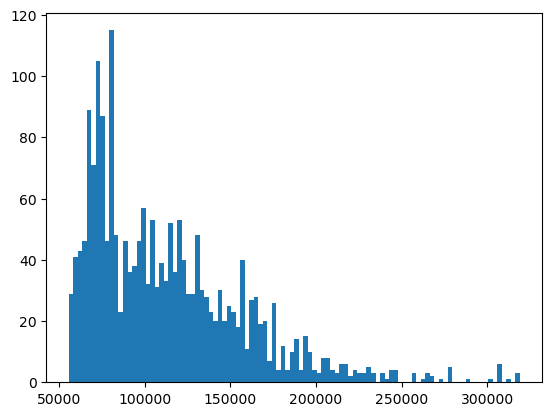

In [47]:
with open("model.pkl", 'rb') as file:
    model = pickle.load(file)

model.fit(X_val, y_val)
y = power_trans.inverse_transform(model.predict(X_val).reshape(-1,1))
plt.hist(y,100);